In [1]:
import thermalizer.models.misc as misc
import thermalizer.kolmogorov.simulate as simulate
import thermalizer.kolmogorov.performance as performance
import torch
import seaborn as sns


import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import numpy as np

In [2]:
sims_cut=20
steps_cut=3000

model_emu=misc.load_model("/scratch/cp3759/thermalizer_data/wandb_data/wandb/run-20240416_052452-12d2m6kr/files/model_weights.pt")
test_data=torch.load("/scratch/cp3759/thermalizer_data/kolmogorov/test_suite/all.pt")
print(test_data.shape)
#test_data=test_data[:sims_cut,:steps_cut]
test_data=test_data[10:15,:steps_cut]
print(test_data.shape)

torch.Size([64, 10000, 64, 64])
torch.Size([5, 3000, 64, 64])


In [3]:
import thermalizer.kolmogorov.util as util
import kymatio
from kymatio.torch import Scattering2D
from torch import optim
import torch.nn.functional as F

class ThermalizeKolmogorovScattering():
    def __init__(self,test_suite,model_emu,thermalize_delay=100,thermalize_interval=5,thermalize_timesteps=1,thermalize_lr=0.05,loss_crit=0.00015):
        self.test_suite=(test_suite/model_emu.config["field_std"])
        self.model_emu=model_emu
        self.scattering=Scattering2D(J=2, shape=(self.test_suite.shape[-1],self.test_suite.shape[-1]), max_order=2)
        self.thermalize_delay=thermalize_delay
        self.thermalize_interval=thermalize_interval
        self.thermalize_timesteps=thermalize_timesteps
        self.thermalize_lr=thermalize_lr
        self.loss_crit=loss_crit
        self.aa=1 ## Step counter

        ## Set up field tensors
        self.emu=torch.zeros(self.test_suite.shape)
        self.therm=torch.zeros(self.test_suite.shape)

        ## Ensure models are in eval
        self.model_emu.eval()
        
        if torch.cuda.is_available():
            self.device=torch.device('cuda')
            ## Put models on GPU
            self.model_emu=self.model_emu.to(self.device)
            self.scattering=self.scattering.cuda()
            ## Put tensors on GPU
            self.test_suite=self.test_suite.to(self.device)
            self.emu=self.emu.to(self.device)
            self.therm=self.therm.to(self.device)

        ## Set t=0 to be the same
        self.emu[:,0,:,:]=self.test_suite[:,0,:,:]
        self.therm[:,0,:,:]=self.test_suite[:,0,:,:]

        self._init_metrics()
        ## Hardcode scattering coeff target for Kolmogorov flow
        self.scattering_target=torch.tensor([0.0, 0.0923, 0.0862, 0.0851, 0.0824, 0.0841, 0.0855, 0.0925, 0.0932, 0.1364,
                                0.1256, 0.1228, 0.1233, 0.1220, 0.1248, 0.1355, 0.1439, 0.0145, 0.0124,
                                0.0093, 0.0079, 0.0074, 0.0076, 0.0094, 0.0130, 0.0125, 0.0142, 0.0121,
                                0.0094, 0.0079, 0.0075, 0.0079, 0.0096, 0.0092, 0.0119, 0.0135, 0.0120,
                                0.0089, 0.0074, 0.0073, 0.0079, 0.0077, 0.0086, 0.0113, 0.0133, 0.0113,
                                0.0086, 0.0076, 0.0077, 0.0074, 0.0075, 0.0089, 0.0119, 0.0135, 0.0118,
                                0.0091, 0.0079, 0.0080, 0.0075, 0.0079, 0.0093, 0.0121, 0.0142, 0.0126,
                                0.0097, 0.0095, 0.0076, 0.0074, 0.0079, 0.0093, 0.0126, 0.0149, 0.0130,
                                0.0124, 0.0091, 0.0077, 0.0076, 0.0077, 0.0092, 0.0126, 0.0149],device=self.device)
        self.scattering_target=self.scattering_target.repeat(len(self.test_suite),1)

    def _init_metrics(self):
        self.mseloss=torch.nn.MSELoss(reduction="none")
        ## Set up metric tensors
        self.mse_auto=torch.zeros(self.test_suite.shape[0],self.test_suite.shape[1])
        self.mse_emu=torch.zeros(self.test_suite.shape[0],self.test_suite.shape[1])
        self.mse_therm=torch.zeros(self.test_suite.shape[0],self.test_suite.shape[1])

        self.autocorr=[]
        self.corr_emu=[]
        self.corr_therm=[]

        self.grid=util.fourierGrid(64)
        self.ke_true=torch.zeros(self.test_suite.shape[0],self.test_suite.shape[1],len(self.grid.k1d_plot))
        self.ke_emu=torch.zeros(self.ke_true.shape)
        self.ke_therm=torch.zeros(self.ke_true.shape)

        ## Log the number of thermalization steps for each sim
        self.therm_steps=torch.zeros((self.test_suite.shape[0],self.test_suite.shape[1]),device=self.device)

        return

    def _scattering_therm(self,inp_field,lr=0.05):
        """ Thermalize using scattering coefficients. Run steps of gradient
            descent on the emulator fields, to match wavelet coefficients of the
            true fields """
        inp_field=inp_field.contiguous().requires_grad_(requires_grad=True)
        optimizer = optim.Adam([inp_field], lr=lr)

        loss=100
        nsteps=0
        while loss>self.loss_crit:
            optimizer.zero_grad()
            new_coefficients=self.scattering(inp_field)
            loss = F.mse_loss(input=torch.mean(new_coefficients,axis=(-2,-1)).squeeze(), target=self.scattering_target)
            #print("Epoch {}, loss: {}".format(aa, loss.item()), end="\r")
            loss.backward()
            optimizer.step()
            nsteps+=1
        return inp_field.squeeze().detach(),nsteps
        
    def step_forward(self):
        ## aa is timestep index
        #for aa in tqdm(range(1,len(self.test_suite[1]))):
        aa=self.aa
        with torch.no_grad():
            ## Step fields forward
            emu_unsq=self.emu[:,aa-1,:,:].unsqueeze(1)
            self.emu[:,aa,:,:]=(self.model_emu(emu_unsq)+emu_unsq).squeeze()
            
            therm_unsq=self.therm[:,aa-1,:,:].unsqueeze(1)
            self.therm[:,aa,:,:]=(self.model_emu(therm_unsq)+therm_unsq).squeeze()
            
        therm_now=self.therm[:,aa,:,:].contiguous()
        #therm_now=self.test_suite[:,aa,:,:].contiguous()

        ## Temporarily do this with a real rollout - this should never need to be thermalized lol

        
        ## Should thermalize? Get scattering coeffs - for all fields with MSE greater
        ## than criterion, run gradient descent
        test_coeffs=self.scattering(therm_now)
        loss=F.mse_loss(input=torch.mean(test_coeffs,axis=(-2,-1)).squeeze(),target=self.scattering_target,reduction="none")
        loss=torch.mean(loss,axis=-1)
        #print(loss)
        #print(loss.shape)

        if torch.max(loss)>self.loss_crit:
            #print("need to thermalize")
            #print(torch.max(loss))
            for bb in range(len(loss)):
                if loss[bb]>self.loss_crit:
                    thermed,steps=self._scattering_therm(therm_now[bb],lr=self.thermalize_lr)
                    self.therm[bb,aa,:,:]=thermed
                    self.therm_steps[bb,aa]=steps
                else:
                    self.therm_steps[bb,aa]=0

        else:
            self.therm_steps[:,aa]=torch.zeros(self.test_suite.shape[0])
                    

        #should_thermalize = (aa % self.thermalize_interval == 0) and (aa>self.thermalize_delay)
        #if should_thermalize:
        #    thermed=self._scattering_therm(self.therm[:,aa,:,:].unsqueeze(1),self.thermalize_timesteps,self.thermalize_lr)
        #    self.therm[:,aa,:,:]=thermed

        ## MSE metrics
        loss=self.mseloss(therm_rollout.test_suite[:,0],therm_rollout.test_suite[:,aa])
        self.mse_auto[:,aa]=torch.mean(loss,dim=(1,2))
        loss=self.mseloss(therm_rollout.test_suite[:,aa],therm_rollout.emu[:,aa])
        self.mse_emu[:,aa]=torch.mean(loss,dim=(1,2))
        loss=self.mseloss(therm_rollout.test_suite[:,aa],therm_rollout.therm[:,aa])
        self.mse_therm[:,aa]=torch.mean(loss,dim=(1,2))
        self.aa+=1

    def evolve(self,counter=None):
        for aa in tqdm(range(1,len(self.test_suite[1]))):
            self.step_forward()

    def _KE_spectra(self):
        ## Move to cpu for KE spectra calculation
        self.test_suite=self.test_suite.to("cpu")
        self.emu=self.emu.to("cpu")
        self.therm=self.therm.to("cpu")
        for aa in tqdm(range(1,len(self.test_suite[1]))):
            for bb in range(0,len(self.test_suite[0])):
                _,ke=util.get_ke(self.test_suite[aa,bb],self.grid)
                self.ke_true[aa,bb]=torch.tensor(ke)
                _,ke=util.get_ke(self.emu[aa,bb],self.grid)
                self.ke_emu[aa,bb]=torch.tensor(ke)
                _,ke=util.get_ke(self.therm[aa,bb],self.grid)

                
                self.ke_therm[aa,bb]=torch.tensor(ke)
  
        ## Move to back to gpu
        self.test_suite=self.test_suite.to(self.device)
        self.emu=self.emu.to(self.device)
        self.therm=self.therm.to(self.device)

In [4]:
therm_rollout=ThermalizeKolmogorovScattering(test_data,model_emu,thermalize_delay=50,thermalize_interval=1,thermalize_timesteps=20,thermalize_lr=0.1,loss_crit=0.00021)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [5]:
therm_rollout.evolve()

  2%|▏         | 67/2999 [00:14<01:38, 29.75it/s]  /state/partition1/job-45985957/ipykernel_1988109/4062100488.py:86: UserWarning: Using a target size (torch.Size([5, 81])) that is different to the input size (torch.Size([81])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(input=torch.mean(new_coefficients,axis=(-2,-1)).squeeze(), target=self.scattering_target)
100%|██████████| 2999/2999 [19:10<00:00,  2.61it/s]


In [ ]:
for aa in tqdm(range(3000)):
    therm_rollout.step_forward()

In [ ]:
therm_rollout.aa

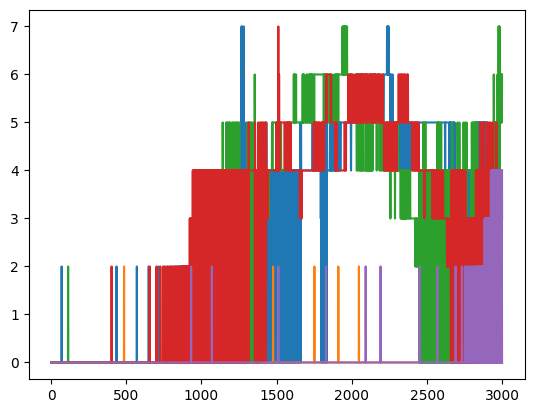

In [6]:
for aa in range(therm_rollout.test_suite.shape[0]):
    plt.plot(therm_rollout.therm_steps[aa].cpu())

In [ ]:
plt.plot(therm_rollout.therm_steps[-2].cpu(),"o")
plt.xlabel("Emulator step")
plt.ylabel("Gradient descent steps")
plt.title("Gradient descent on scattering moments during emulator rollout")

In [ ]:
mse_ave=torch.load("/scratch/cp3759/thermalizer_data/kolmogorov/sim_diverge.pt")//model_emu.config["field_std"]

Text(0.5, 0, '# of steps')

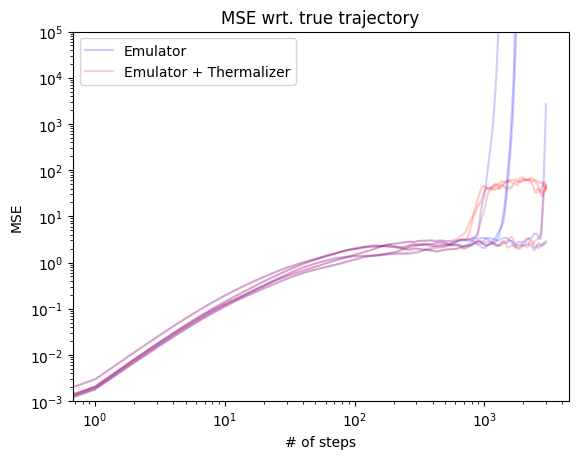

In [7]:
plt.title("MSE wrt. true trajectory")
plt.loglog(therm_rollout.mse_emu[0],color="blue",alpha=0.2,label="Emulator")
plt.loglog(therm_rollout.mse_therm[0],color="red",alpha=0.2,label="Emulator + Thermalizer")
for aa in range(1,len(therm_rollout.mse_auto)):
    #plt.loglog(therm_rollout.mse_auto[aa],color="gray",alpha=0.4)
    plt.loglog(therm_rollout.mse_emu[aa],color="blue",alpha=0.2)
    plt.loglog(therm_rollout.mse_therm[aa],color="red",alpha=0.2)
plt.ylim(1e-3,1e5)
plt.legend()
plt.ylabel("MSE")
plt.xlabel("# of steps")

Text(0.5, 0, '# of steps')

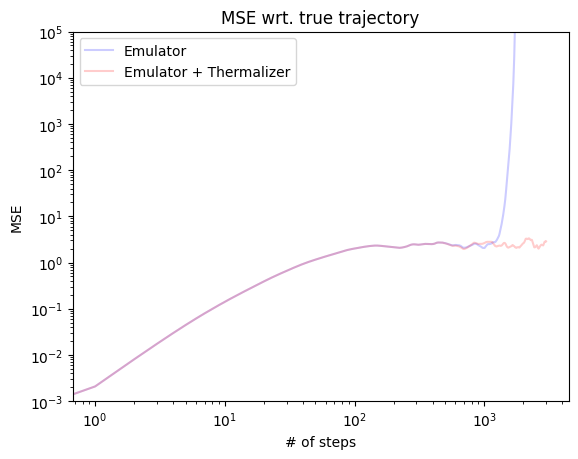

In [11]:
plt.title("MSE wrt. true trajectory")
plt.loglog(therm_rollout.mse_emu[1],color="blue",alpha=0.2,label="Emulator")
plt.loglog(therm_rollout.mse_therm[1],color="red",alpha=0.2,label="Emulator + Thermalizer")
plt.ylim(1e-3,1e5)
plt.legend()
plt.ylabel("MSE")
plt.xlabel("# of steps")

In [12]:
therm_rollout.aa//2

1500

In [ ]:
plt.title("MSE wrt. true trajectory")
plt.loglog(therm_rollout.mse_emu[0],color="blue",alpha=0.1,label="Emulator")
plt.loglog(therm_rollout.mse_therm[0],color="red",alpha=0.1,label="Emulator + Thermalizer")
for aa in range(1,len(therm_rollout.mse_auto)):
    #plt.loglog(therm_rollout.mse_auto[aa],color="gray",alpha=0.4)
    plt.loglog(therm_rollout.mse_emu[aa],color="blue",alpha=0.1)
    plt.loglog(therm_rollout.mse_therm[aa],color="red",alpha=0.1)
plt.ylim(6e-1,1e2)
plt.xlim(6e1,3e2)
plt.legend()
plt.ylabel("MSE")
plt.xlabel("# of steps")

In [ ]:
therm_rollout.scattering_target.shape

In [ ]:
test_field=therm_rollout.test_suite[0,12]
plt.figure()
plt.imshow(test_field.cpu(),cmap=sns.cm.icefire)
plt.colorbar()
before_coefficients = therm_rollout.scattering(test_field)


new_field=therm_rollout._scattering_therm(torch.clone(test_field.unsqueeze(0).unsqueeze(0)),20,lr=0.001)
plt.figure()
plt.imshow(new_field.squeeze().cpu(),cmap=sns.cm.icefire)
plt.colorbar()
new_coefficients = therm_rollout.scattering(new_field.squeeze())
plt.figure()
plt.plot(torch.mean(before_coefficients[17:],axis=(-2,-1)).cpu(),"x")
plt.plot(torch.mean(new_coefficients[17:],axis=(-2,-1)).cpu(),"+")
plt.plot(therm_rollout.scattering_target[0].cpu(),"o",color="black")
#plt.ylim(0.005,0.027)

In [ ]:
## Inspect an individual gradient descent~few steps

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.animation as animation
from IPython.display import HTML

import thermalizer.kolmogorov.util as util


class KolmogorovAnimationScattering():
    def __init__(self,rollout,batch=1,fps=10,nSteps=1000,savestring=None,skip=1):
        """ 
            """
        self.rollout=rollout
        self.rollout.test_suite=self.rollout.test_suite.to("cpu")
        self.rollout.emu=self.rollout.emu.to("cpu")
        self.rollout.therm=self.rollout.therm.to("cpu")
        self.batch=batch
        self.fps=fps
        self.nSteps=nSteps
        self.skip=skip
        self.nFrames=int(self.nSteps)
        self.scattering=Scattering2D(J=2, shape=(64,64), max_order=2)
        
        self.mse=[]
        self.correlation=[]
        self.correlation_therm=[]
        self.autocorrelation=[]
        self.criterion=nn.MSELoss()
        self.times=np.arange(0,self.nFrames+0.001,1)

        self.residuals=None
        self.savestring=savestring
        self.grid=grid=util.fourierGrid(64)
        self.k1d_plot,self.ketrue=util.get_ke(self.rollout.test_suite[self.batch,0],self.grid)
        self.k1d_plot,self.kepred=util.get_ke(self.rollout.emu[self.batch,0],self.grid)
        self.k1d_plot,self.ketherm=util.get_ke(self.rollout.therm[self.batch,0],self.grid)
        self.i=0
        
    def _update_metrics(self):
        """ Update metrics for next timestep """
        #self.correlation.append(pearsonr(self.rollout.emu[self.batch,self.i].numpy().flatten(),self.rollout.test_suite[self.batch,self.i].numpy().flatten())[0])
        #self.correlation_therm.append(pearsonr(self.rollout.therm[self.batch,self.i].numpy().flatten(),self.rollout.test_suite[self.batch,self.i].numpy().flatten())[0])
        #self.autocorrelation.append(pearsonr(self.rollout.test_suite[self.batch,0].numpy().flatten(),self.rollout.test_suite[self.batch,self.i].numpy().flatten())[0])
        #self.mse.append(self.criterion(self.rollout.emu[self.batch,self.i],self.rollout.test_suite[self.batch,self.i]))

        _,self.ketrue=util.get_ke(self.rollout.test_suite[self.batch,self.i],self.grid)
        _,self.kepred=util.get_ke(self.rollout.emu[self.batch,self.i],self.grid)
        _,self.ketherm=util.get_ke(self.rollout.therm[self.batch,self.i],self.grid)

        scattering_coefficients = self.scattering(self.rollout.test_suite[self.batch,self.i])
        self.scat_true=torch.mean(scattering_coefficients[1:],dim=(1,2))
        scattering_coefficients = self.scattering(self.rollout.emu[self.batch,self.i])
        self.scat_pred=torch.mean(scattering_coefficients[1:],dim=(1,2))
        scattering_coefficients = self.scattering(self.rollout.therm[self.batch,self.i])
        self.scat_therm=torch.mean(scattering_coefficients[1:],dim=(1,2))
        
        return
    
    def animate(self):
        fig, axs = plt.subplots(2, 4,figsize=(14,6))
        self.ax1=axs[0][0].imshow(self.rollout.test_suite[self.batch,self.i], cmap=sns.cm.icefire,interpolation='none')
        fig.colorbar(self.ax1, ax=axs[0][0])
        axs[0][0].set_xticks([]); axs[0][0].set_yticks([])
        axs[0][0].set_title("Simulation")

        self.ax2=axs[0][1].imshow(self.rollout.emu[self.batch,self.i], cmap=sns.cm.icefire,interpolation='none')
        fig.colorbar(self.ax2, ax=axs[0][1])
        axs[0][1].set_xticks([]); axs[0][1].set_yticks([])
        axs[0][1].set_title("Emulator")

        self.ax3=axs[0][2].imshow(self.rollout.test_suite[self.batch,self.i]-self.rollout.emu[self.batch,self.i], cmap=sns.cm.icefire,interpolation='none')
        fig.colorbar(self.ax3, ax=axs[0][2])
        axs[0][2].set_xticks([]); axs[0][2].set_yticks([])
        axs[0][2].set_title("Residuals")
        
        ## Time evol metrics
        axs[0][3].set_title("Scattering coefficients")
        self.ax4=[axs[0][3].plot(-1),axs[0][3].plot(-1),axs[0][3].plot(-1),axs[0][3].plot(self.rollout.scattering_target[0].cpu(),"o",color="black",alpha=0.5)]
        axs[0][3].set_yscale("log")
        axs[0][3].set_ylim(0.0025,0.375)
        
        #axs[0][3].set_xlim(-1,81)

        ## Lower layer
        self.ax5=axs[1][0].imshow(self.rollout.test_suite[self.batch,self.i], cmap=sns.cm.icefire,interpolation='none')
        fig.colorbar(self.ax5, ax=axs[1][0])
        axs[1][0].set_xticks([]); axs[1][0].set_yticks([])
        axs[1][0].set_title("Simulation")
        
        self.ax6=axs[1][1].imshow(self.rollout.therm[self.batch,self.i], cmap=sns.cm.icefire,interpolation='none')
        fig.colorbar(self.ax6, ax=axs[1][1])
        axs[1][1].set_xticks([]); axs[1][1].set_yticks([])
        axs[1][1].set_title("Thermalized")

        self.ax7=axs[1][2].imshow(self.rollout.test_suite[self.batch,self.i]-self.rollout.therm[self.batch,self.i], cmap=sns.cm.icefire,interpolation='none')
        fig.colorbar(self.ax7, ax=axs[1][2])
        axs[1][2].set_xticks([]); axs[1][2].set_yticks([])
        axs[1][2].set_title("Residuals")

        axs[1][3].set_title("KE spectra")
        axs[1][3].set_ylim(1e1,1e7)
        axs[1][3].set_xlim(6e-1,3.5e1)
        self.ax8=[axs[1][3].loglog(-1,label="Simulation"),axs[1][3].loglog(-1,label="Emulator"),axs[1][3].loglog(-1,label="Thermalized")]
        axs[1][3].legend()
        self.ax8[0][0].set_xdata(self.k1d_plot)
        self.ax8[0][0].set_ydata(self.ketrue)
        
        
        self.ax8[1][0].set_xdata(self.k1d_plot)
        self.ax8[1][0].set_ydata(self.kepred)

        self.ax8[2][0].set_xdata(self.k1d_plot)
        self.ax8[2][0].set_ydata(self.ketherm)
        
        self.time_text=axs[0][2].text(-20,-20,"")
        
        
        fig.tight_layout()
        
        anim = animation.FuncAnimation(
                                       fig, 
                                       self.animate_func, 
                                       frames = self.nFrames,
                                       interval = 1000 / self.fps, # in ms
                                       )
        plt.close()
        
        if self.savestring:
            print("saving")
            # saving to m4 using ffmpeg writer 
            writervideo = animation.FFMpegWriter(fps=self.fps) 
            anim.save('%s.mp4' % self.savestring, writer=writervideo) 
            plt.close()
        else:
            return HTML(anim.to_html5_video())
        
    def animate_func(self,i):
        if i % self.fps == 0:
            print( '.', end ='' )
            
        self.i=self.skip*i
        self._update_metrics()
        self.time_text.set_text("%d timesteps" % (self.i))
    
        ## Set image and colorbar for each panel
        image=self.rollout.test_suite[self.batch,self.i]
        lim=torch.max(torch.abs(image))
        self.ax1.set_array(image)
        self.ax1.set_clim(-lim,lim)
        
        image=self.rollout.emu[self.batch,self.i]
        lim=torch.max(torch.abs(image))
        self.ax2.set_array(image)
        self.ax2.set_clim(-lim,lim)
        
        image=self.rollout.test_suite[self.batch,self.i]-self.rollout.emu[self.batch,self.i]
        lim=torch.max(torch.abs(image))
        self.ax3.set_array(image)
        self.ax3.set_clim(-lim,lim)
 
        self.ax4[0][0].set_xdata(np.arange(len(self.scat_true)))
        self.ax4[0][0].set_ydata(self.scat_true)
        
        self.ax4[1][0].set_xdata(np.arange(len(self.scat_true)))
        self.ax4[1][0].set_ydata(self.scat_pred)

        self.ax4[2][0].set_xdata(np.arange(len(self.scat_true)))
        self.ax4[2][0].set_ydata(self.scat_therm)

        ## Lower panel
        image=self.rollout.test_suite[self.batch,self.i]
        lim=torch.max(torch.abs(image))
        self.ax5.set_array(image)
        self.ax5.set_clim(-lim,lim)
        
        image=self.rollout.therm[self.batch,self.i]
        lim=torch.max(torch.abs(image))
        self.ax6.set_array(image)
        self.ax6.set_clim(-lim,lim)
        
        image=self.rollout.test_suite[self.batch,self.i]-self.rollout.therm[self.batch,self.i]
        lim=torch.max(torch.abs(image))
        self.ax7.set_array(image)
        self.ax7.set_clim(-lim,lim)


        
        self.ax8[0][0].set_xdata(self.k1d_plot)
        self.ax8[0][0].set_ydata(self.ketrue)
        
        self.ax8[1][0].set_xdata(self.k1d_plot)
        self.ax8[1][0].set_ydata(self.kepred)

        self.ax8[2][0].set_xdata(self.k1d_plot)
        self.ax8[2][0].set_ydata(self.ketherm)
        return 

In [20]:
anim=KolmogorovAnimationScattering(therm_rollout,batch=1,nSteps=1499,fps=90,skip=2)

In [ ]:
anim.animate()

..........

In [23]:
print("ok")

ok


In [ ]:
torch.tensor([0.0145, 0.0124, 0.0093, 0.0079, 0.0074, 0.0076, 0.0094, 0.0130, 0.0125,
        0.0142, 0.0121, 0.0094, 0.0079, 0.0075, 0.0079, 0.0096, 0.0092, 0.0119,
        0.0135, 0.0120, 0.0089, 0.0074, 0.0073, 0.0079, 0.0077, 0.0086, 0.0113,
        0.0133, 0.0113, 0.0086, 0.0076, 0.0077, 0.0074, 0.0075, 0.0089, 0.0119,
        0.0135, 0.0118, 0.0091, 0.0079, 0.0080, 0.0075, 0.0079, 0.0093, 0.0121,
        0.0142, 0.0126, 0.0097, 0.0095, 0.0076, 0.0074, 0.0079, 0.0093, 0.0126,
        0.0149, 0.0130, 0.0124, 0.0091, 0.0077, 0.0076, 0.0077, 0.0092, 0.0126,
        0.0149])